# Boston Precios de Casas Regretsion

In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importando Data

In [2]:
from keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets)=boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 2us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [6]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

## Normalizacion de los datos

In [7]:
# usando media y std de los datos de train

mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)

train_data /= std
test_data -= mean
test_data /= std

## Modelo

In [8]:
from keras import models
from keras import layers

# se va a iniciar varias veces, por eso en funcion
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                            input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # un nodo, una salida lineal (regresion)
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

## Validacion K-Fold

In [9]:
import numpy as np

k=4   # k particiones de los datos

num_val_samples = len(train_data) // k   # muestras

num_epochs = 100 # epocas
all_scores = []  # metricas error

In [10]:
# para cada particion de datos..
for i in range(k):
    print('processing fold #', i)
    # datos validacion
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # datos entrenamiento
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
                                          train_data[(i + 1) * num_val_samples:]], 
                                        axis=0)
    
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
                                             train_targets[(i + 1) * num_val_samples:]], 
                                           axis=0)
    
    # se inicia el modelo y se entrena
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # metricas de error
    val_mse, val_mae = model.evaluate(val_data, val_targets, 
                                      verbose=0)
    
    # error medio absoluto
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
all_scores

[2.103940586052319, 2.2305029005107313, 2.8739123745719986, 2.3884814995350223]

## Guardando logs de validacion en cada fold

In [12]:
num_epochs = 500 
all_mae_histories = []

In [13]:
for i in range(k):
    print('processing fold #', i)
    # datos validacion
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # datos entrenamiento
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
                                          train_data[(i + 1) * num_val_samples:]], 
                                        axis=0)
    
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
                                             train_targets[(i + 1) * num_val_samples:]], 
                                           axis=0)
    
    # se inicia el modelo y se entrena
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) 
    
    # error medio absoluto validacion
    mae_history = history.history['val_mean_absolute_error']
    
    
    all_mae_histories.append(mae_history)
    
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Construyendo historico 

In [14]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## Plots validacion

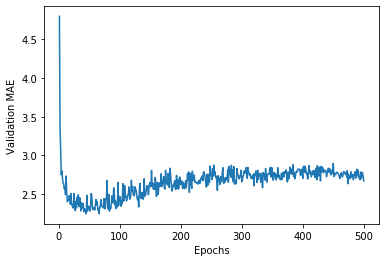

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show();

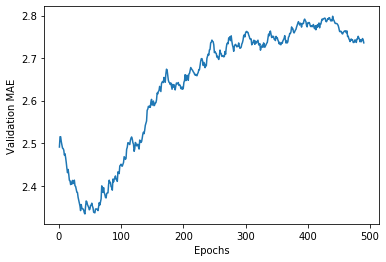

In [16]:
# suavizado y eliminado de los 10 primeros elementos

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points



smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show();

## Modelo Final

In [17]:
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)


test_mse_score, test_mae_score = model.evaluate(test_data, 
                                                test_targets)

102/102 [==============================] - 0s 760us/step


In [18]:
test_mae_score

2.68151548797009